In [2]:
# to suppress futurewarnings caused by pandas and other libraries not updating their numpy interface codes
# apparently has to come before these import, so leave this on top
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import scipy.stats as stats
import pandas as pd

%matplotlib inline

# Chapter 5
* **multivariate regression**: using more than one predictor variable to model an outcome. useful b/c
  * control for confounds. **confound**: variable that might be correlated w/ variable of interest, e.g. nr of waffle houses and divorce rate. can hide important variables or can create false importance. **simpson's paradox**: reverse direction between predictor and outcome due to confound.
  * multiple causation. something might be caused by more than one thing
  * interactions. car needs fuel and spark to start, only one does not have any effect.
* this chapter: confounds and multiple causation
* also danger: multicollinerarity
* **rethinking: causal inference:** extremely important, but no unified approach to determine causal effect, neither in sciences nor in statistic. furthermore, 'cause' loses clear meaning in complex systems in which everything seems to cause everything (and be caused by it). consensus: inference of causality always rests upon unverifiable assumptions. so no matter the analysis, there will always be possible criticism about whether there really is causality. however: even despite that useful work can be done

## 5.1. Spurious association
* impact of median marriage age of marriage on divorce rate

In [3]:
# Code 5.1
d = pd.read_csv('./data/WaffleDivorce.csv', sep=';')

In [4]:
d.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [5]:
d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean()) / d.MedianAgeMarriage.std()

with pm.Model() as m5_1:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    bA = pm.Normal('bA', mu=0, sd=1)
    
    a = pm.Normal('a', mu=10, sd=10)
    
    mu = pm.Deterministic('mu', a + bA * d.MedianAgeMarriage_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    
    trace_m5_1 = pm.sample(draws=1000, tune=1000)

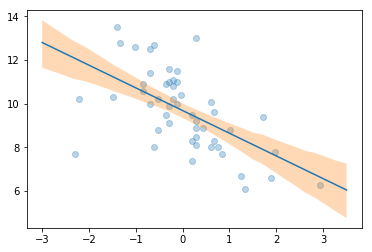

In [16]:
# Code 5.2
MAM_seq = np.linspace(-3, 3.5, 30)
mu = np.reshape(trace_m5_1['a'], (-1, 1)) + np.reshape(trace_m5_1['bA'], (-1, 1)) * np.reshape(MAM_seq, (1, -1))
mu_PI = pm.hpd(mu, alpha=.11)
mu_mean = mu.mean(axis=0)

plt.scatter(x=d.MedianAgeMarriage_s, y=d.Divorce, alpha=.3);
plt.plot(MAM_seq, mu_mean);
plt.fill_between(x=MAM_seq, y1=mu_PI[:, 0], y2=mu_PI[:, 1], alpha=.3);

In [18]:
varnames = ['bA', 'a', 'sigma']

In [19]:
pm.summary(trace_m5_1, varnames=varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bA,-1.038823,0.218167,0.003869,-1.438348,-0.611611,2569.096534,1.000454
a,9.688426,0.209601,0.004726,9.275081,10.088179,2353.978188,1.000037
sigma,1.514978,0.155424,0.002958,1.232519,1.820205,2344.748869,0.999586


In [25]:
# Code 5.3
d['Marriage_s'] = (d.Marriage - d.Marriage.mean()) / d.Marriage.std()

with pm.Model() as m5_2:
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    bR = pm.Normal('bR', mu=0, sd=1)
    
    a = pm.Normal('a', mu=10, sd=10)
    
    mu = pm.Deterministic('mu', a + bR * d.Marriage_s)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    
    trace_m5_2 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, sigma]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1222.33draws/s]


In [26]:
pm.summary(trace_m5_2, varnames=['sigma', 'bR', 'a'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
sigma,1.749005,0.184326,0.003506,1.388940,2.095807,2235.882688,0.999583
bR,0.639685,0.240040,0.004679,0.164433,1.099025,2639.975623,0.999509
a,9.685888,0.251515,0.004926,9.180704,10.163237,2495.343288,0.999508


* median age of marriage has stronger association with divorce rate than the one that marriage rate has
* however, does not answer which one is better predictor. they could have independent information, or be redundant or could eliminate each other
* want to build multivariate model to determine partial value added by each predictor. in particular, question is **what is predictive value of variable once i know value of all variables?**
* **rethinking: "control" is outside of control** this question often talked about as 'statistical control'. estimating effect of one variable while controlling for effect of another. however: sloppy language. implies causality ('effect') and dissasociation of predictors ('control'), neither of which is a fact in the model, even though it might be made by analyst. power of statistical methods does not extend to this, must be careful not to make this wrong impression, otherwise interpretation of results will also be based on wrong understanding

### 5.1.1. multivariate notation
* straightforward extension of univariate models, just add multiple parameters into formula for mean and add priors for their parameters for all of them
* what does $\mu_i = \alpha + \beta_R R_i + \beta_A A_i$ mean? expected outcome for any state is sum of three independent terms. can be read as "divorce rate can function of marriage rate ($R_i$) OR median marriage age ($A_i$)". "OR" implies that both factors are independent
* **overthinking: design matrix** **design matrix** = matrix of features with additional column of '1's in the beginning. used in equation $m = Xb$, where $m$ = predicted means (one for each row of data), $X$ = design matrix w/ one row per row of data, one col per predictor and extra '1' col and $b$ = col vector of parameters

### 5.1.2. fitting the model
* exactly as expected

In [27]:
# Code 5.4
with pm.Model() as m5_3:
    bR = pm.Normal('bR', mu=0, sd=1)
    bA = pm.Normal('bA', mu=0, sd=1)
    a = pm.Normal('a', mu=10, sd=10)
    mu = pm.Deterministic('mu', a + bR * d.Marriage_s + bA * d.MedianAgeMarriage_s)
    
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    Divorce = pm.Normal('Divorce', mu=mu, sd=sigma, observed=d.Divorce)
    
    trace_m5_3 = pm.sample(draws=1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, a, bA, bR]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 776.41draws/s]


In [28]:
pm.summary(trace_m5_3, varnames=['bR', 'bA', 'a', 'sigma'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
bR,-0.111189,0.292416,0.008058,-0.658546,0.460271,1175.018517,1.000177
bA,-1.115233,0.295339,0.007973,-1.705425,-0.554056,1295.263341,0.999556
a,9.691552,0.220495,0.004993,9.227591,10.086638,1603.004835,0.999574
sigma,1.529497,0.163340,0.004119,1.233126,1.870195,1567.145286,1.002618


In [68]:
params = ['sigma', 'bA', 'bR', 'a']

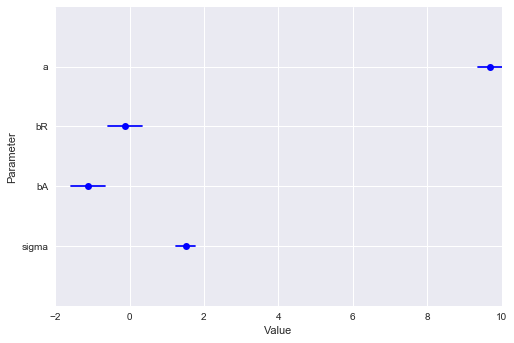

In [91]:
# Code 5.5
plt.style.use('seaborn-notebook')
fig, ax = plt.subplots()
# ax.plot([1, 2, 3], [1, 2, 3])
ax.set(xlabel='Value', ylabel='Parameter')
ax.set_xlim(-2, 10)
ax.set_ylim(0, 5)
ax.set_yticks([1, 2, 3, 4])
ax.set_yticklabels(params)
for ix, pname in enumerate(params):
    ax.plot(trace_m5_3[pname].mean(), ix+1, 'ob')
    hpd_boundaries = pm.hpd(trace_m5_3[pname], alpha=.11)
    ax.plot(hpd_boundaries, [ix+1, ix+1], '-b')

In [86]:
hpd_boundaries

array([9.64769616, 9.69837857])

In [75]:
from matplotlib.lines import Line2D
Line2D.fillStyles

('full', 'left', 'right', 'bottom', 'top', 'none')

In [57]:
xaxis = ax.get_xaxis()

In [ ]:
xaxis.set

In [38]:
print(plt.style.available)


['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']
